In [1]:
import sys
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from textwrap import wrap

# visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# seaborn styling default
sns.set_theme(style='darkgrid')

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('derived_data/combined_dataset.csv', index_col = [0])

## Visiualise the Data

In [3]:
df['Actiware classification'].value_counts()

0.0    36335
1.0     2429
Name: Actiware classification, dtype: int64

In [4]:
sleep_wake = np.array([36335,2034])
labels = ['Sleep', 'Wake']

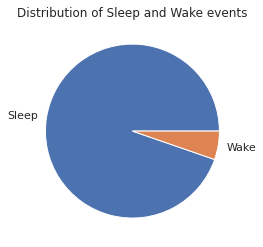

In [5]:
plt.pie(sleep_wake, labels = labels)
plt.title('Distribution of Sleep and Wake events')
plt.show() 

In [6]:
sleep_wake[1]/sleep_wake[0]

0.05597908352827852

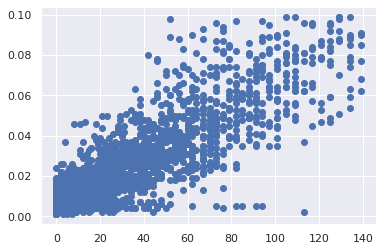

In [7]:
plt.scatter(df['Actiwatch activity counts'], df['Apple Watch ENMO'])

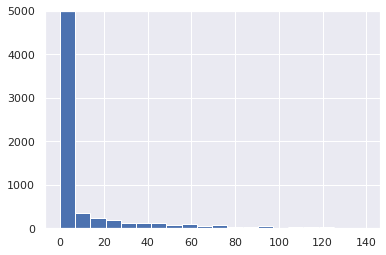

In [8]:

n_bins = 20

# Generate two normal distributions
dist1 = df['Actiwatch activity counts']
plt.ylim(0,5000)
plt.hist(dist1, bins = n_bins)
plt.show()

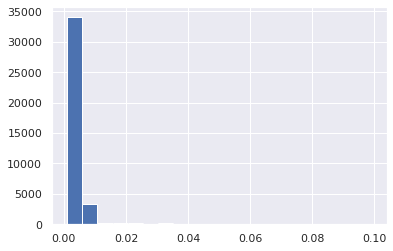

In [9]:
n_bins = 20

# Generate two normal distributions
dist1 = df['Apple Watch ENMO']
plt.hist(dist1, bins = n_bins)
plt.show()

### Sample stratify Data for model building


In [10]:
df_x = df[['Apple Watch ENMO', 'ELMO_before','ELMO_after']].copy()
df_y  = df[['Actiwatch activity counts']].copy()
df_strat = df[['Actiware classification']].copy()
nums_x = df_x.to_numpy()
nums_y = df_y.to_numpy()
strat = df_strat.to_numpy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(nums_x, nums_y, test_size=0.33, random_state=42, stratify=strat)
X_train = X_train.astype('float64')
y_train = y_train.astype('int')
X_test = X_test.astype('float64')
y_test = y_test.astype('int')

### Define functions for testing

Applies the  Philips’ Actiware software algorithm to a dataframe and returns a new dataframe with a column predicted_actiwatch whihc contains the totals counts for the given row

In [12]:
def phillips_alogrithn(df):
    for index, row in df.iterrows():
        if index <= 8 or index >= len(df.index)-8:
            continue

        #part 1
        p1 = 0
        for i in range(-8,-4):
            j = index + i
            p1 = p1 + abs(df.loc[j]['predicted_actiwatch'])

        #part 2
        p2 = 0
        for i in range(-4,0):
            j = index + i
            p2 = p2 + abs(df.loc[j]['predicted_actiwatch'])

        #part 3
        p3 = 0
        for i in range(1,5):
            j = index + i
            p3 = p3 + abs(df.loc[j]['predicted_actiwatch'])

        #part 4
        p4 = 0
        for i in range(5,9):
            j = index + i
            p4 = p4 + abs(df.loc[j]['predicted_actiwatch'])

        #Calculate total counts
        df.at[index, 'total_counts'] = 0.04*p1 + 0.2*p2 + 4*abs(df.loc[index]['predicted_actiwatch']) + 0.2*p3 + 0.04*p4

        #Calculate Actual total counts
        #part 1
        p1 = 0
        for i in range(-8,-4):
            j = index + i
            p1 = p1 + df.loc[j]['Actiwatch activity counts']

        #part 2
        p2 = 0
        for i in range(-4,0):
            j = index + i
            p2 = p2 + df.loc[j]['Actiwatch activity counts']

        #part 3
        p3 = 0
        for i in range(1,5):
            j = index + i
            p3 = p3 + df.loc[j]['Actiwatch activity counts']

        #part 4
        p4 = 0
        for i in range(5,9):
            j = index + i
            p4 = p4 + df.loc[j]['Actiwatch activity counts']

        #Calculate total counts
        df.at[index, 'total_counts_actual'] = 0.04*p1 + 0.2*p2 + 4*df.loc[index]['Actiwatch activity counts'] + 0.2*p3 + 0.04*p4

    return df



Simple function given a threshold and total count returns 1 for awake and zero for sleep

In [13]:
def predict_sleep_awake(row, threshold):
    if row['total_counts'] <= threshold:
        return 0
    else:
        return 1

def predict_sleep_awake_actual(row, threshold):
    if row['total_counts_actual'] <= threshold:
        return 0
    else:
        return 1


    

Given a patient file, sklearn model and threshold returns a dataframe with sleep/wake prediction for patient

In [14]:
def test_model_on_patient(patientFile, model, threshold):
    #import patient file
    import_df = pd.read_csv('derived_data/'+ patientFile +'.csv')

    #Grab fields required for prediction
    test_df = import_df[['Apple Watch ENMO','ELMO_before','ELMO_after']].copy()
    test_nums = test_df.to_numpy()

    #predict actiwatch counts
    predict = model.predict(test_nums).astype('int')
    import_df['predicted_actiwatch']= predict

    #determine total counts
    predicted_df = phillips_alogrithn(import_df)

    #determine sleep or awake
    predicted_df['predicted_sleep'] = predicted_df.apply (lambda row: predict_sleep_awake(row, threshold), axis=1)
    predicted_df['predicted_sleep_dervied'] = predicted_df.apply (lambda row: predict_sleep_awake_actual(row, threshold), axis=1)

    return predicted_df

   


Uses confunsion matrix tp determine accuracy

In [15]:
def check_accuracy(df):
    #sleep is zero, awake is one
    df_accuracy = df.dropna(subset=['Actiware classification']).copy()

    TP=0
    TN=0
    FP=0
    FN=0

    for index, row in df_accuracy.iterrows():
        if row['Actiware classification'] == 1 and row['predicted_sleep'] == 1:
            TN+=1
        if row['Actiware classification'] == 1 and row['predicted_sleep'] == 0:
            FP+=1
        if row['Actiware classification'] == 0 and row['predicted_sleep'] == 0:
            TP+=1
        if row['Actiware classification'] == 0 and row['predicted_sleep'] == 1:
            FN+=1
    
    accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
    sensitivity = (TP/(TP+FN))*100 #Recall
    precision  = (TP/(TP+FP))*100 
    fnr = (FN/(TP+FN))*100 #False Negative Rate
    specificity  = (TN/(TN+FP))*100 
    fpr = 100 - specificity #False Positive Rate
    return accuracy, sensitivity, fnr, specificity, fpr, precision

Check accuracy on multiple datasets

In [16]:
from numpy import average


def check_overall_accuracy(model, threshold):
    accuracies = []
    sensitivitys = []
    fnrs = []
    specificitys = []
    fprs = []
    precisions = []
    fileNames = ['P02_N1', 'P02_N2', 'P03_N1', 'P03_N2','P04_N1','P04_N2','P05_N1', 'P05_N2','P06_N1','P06_N2','P07_N1','P07_N2','P11_N1','P11_N2','P12_N1','P12_N2','P14_N1',
    'P14_N2','P15_N2','P16_N1','P16_N2','P17_N1']
    for fileName in fileNames:
        file = fileName + '_filtered'
        df1 = test_model_on_patient(file, model, threshold)
        accuracy, sensitivity, fnr, specificity, fpr, precision = check_accuracy(df1)
        accuracies.append(accuracy)
        sensitivitys.append(sensitivity)
        fnrs.append(fnr)
        specificitys.append(specificity)
        fprs.append(fpr)
        precisions.append(precision)
    
    recall = average(sensitivitys)
    Precision = average(precisions)
    f1 = (2*Precision*recall)/(recall+Precision)

    output = "Accuracy: " + str(average(accuracies)) +"\nSensitivity: "+ str(recall)+"\nFalse Negative Rate: "+ str(average(fnrs))+"\nSpecificity: "+ str(average(specificitys))+"\nFalse Positive Rate: "+ str(average(fprs)) + " \nF measure: "+ str(f1)
    return output




Implement the rule  when using actigraphy, it is common to look for the first 5 minutes of uninterrupted sleep, and set all the epochs before that to wake, and then the last 5 minutes of uniterrupted sleep, and also set all the epochs after that to wake. You may want to do this as well.

In [17]:
def sleep_index_finder(df, column_name):
 
    Go = True
    index_start = 0
    #How long until we classify as asleep
    epochs = 20
    while Go:
        if df.iloc[index_start][column_name] == 0:
            epochs -= 1
        else:
            epochs = 20
        
        if epochs == 0:
            Go = False
        else:
            index_start += 1

    #Start index minus last 5 minutes of sleep
    index_start -= 20

    ##Find the index to end on

    #end of sleep minus 5 minutes
    Go = True
    index_end = len(df) -1
    #How long until we classify as asleep
    epochs = 20
    while Go:
        if df.iloc[index_end][column_name] == 0:
            epochs -= 1
        else:
            epochs = 20
        
        if epochs == 0:
            Go = False
        else:
            index_end -= 1

    #End index plus last 5 minutes of sleep
    index_end += 20

    return index_start, index_end

Make a new df implementing this rule

In [18]:
def implement_sleep_wake_rule(df):
    start_predicted, end_predicted = sleep_index_finder(df, 'predicted_sleep')
    start_actual, end_actual = sleep_index_finder(df, 'Actiware classification')

    df.loc[0:start_predicted,'predicted_sleep'] = 1
    df.loc[end_predicted:len(df.index),'predicted_sleep'] = 1

    df.loc[0:start_actual,'Actiware classification'] = 1
    df.loc[end_actual:len(df.index),'Actiware classification'] = 1

    df = df.dropna(subset=['Actiwatch activity counts', 'total_counts'])

    df['Time'] = pd.to_datetime(df['timestamp']).dt.time

    return df, start_predicted, end_predicted, start_actual, end_actual

In [19]:
def sleep_metrics(df_predicted):
    df_dervied, start_predicted, end_predicted, start_actual, end_actual = implement_sleep_wake_rule(df_predicted)
    df_actual = df_dervied.copy()
    #Trim dataframe to online sleep classifed sleep
    #start indexs to drop
    start_indexs = list(range(df_dervied.index[0], start_predicted+1))
    #end indexs to drop
    end_indexs = list(range(end_predicted, df_dervied.index[len(df_dervied)-1]+1))
    #drop indexs
    df_dervied.drop(start_indexs, inplace = True)
    df_dervied.drop(end_indexs, inplace = True)

    #calculate sleep metrics
    WASO_predicted = (sum(df_dervied['predicted_sleep']))*15
    TST_predicted = (df_dervied.shape[0] - sum(df_dervied['predicted_sleep']))*15

    current_awake = False
    number_of_wakes = 0
    nums_wake_events_predicted = 0
    for index, row in df_dervied.iterrows():
        if current_awake == False and row['predicted_sleep'] == 1:
            current_awake = True
            number_of_wakes = 1
        
        if current_awake == True:
            if row['predicted_sleep'] == 1:
                number_of_wakes += 1
            if row['predicted_sleep'] == 0:
                current_awake = False
                if number_of_wakes >= 2:
                    nums_wake_events_predicted += 1
    
    #Actual Dataset
    #start indexs to drop
    start_indexs = list(range(df_actual.index[0], start_actual+1))
    #end indexs to drop
    end_indexs = list(range(end_actual, df_actual.index[len(df_actual)-1]+1))
    #drop indexs
    df_actual.drop(start_indexs, inplace = True)
    df_actual.drop(end_indexs, inplace = True)

    #calculate sleep metrics
    WASO_actual = (sum(df_actual['Actiware classification']))*15
    TST_actual = (df_actual.shape[0] - sum(df_actual['Actiware classification']))*15

    current_awake = False
    number_of_wakes = 0
    nums_wake_events_actual = 0
    for index, row in df_actual.iterrows():
        if current_awake == False and row['Actiware classification'] == 1:
            current_awake = True
            number_of_wakes = 1
        
        if current_awake == True:
            if row['Actiware classification'] == 1:
                number_of_wakes += 1
            if row['Actiware classification'] == 0:
                current_awake = False
                if number_of_wakes >= 2:
                    nums_wake_events_actual += 1
    



    return WASO_predicted, TST_predicted, nums_wake_events_predicted, WASO_actual, TST_actual, nums_wake_events_actual

In [20]:
def get_overall_sleep_metrics(model, threshold):
    WASO_predicteds = []
    TST_predicteds = []
    nums_wake_events_predicteds = []
    WASO_actuals = []
    TST_actuals= []
    nums_wake_events_actuals = []
    fileNames = ['P02_N1', 'P02_N2', 'P03_N1', 'P03_N2','P04_N1','P04_N2','P05_N1', 'P05_N2','P06_N1','P06_N2','P07_N1','P07_N2','P11_N1','P11_N2','P12_N1','P12_N2','P14_N1',
    'P14_N2','P15_N2','P16_N1','P16_N2','P17_N1']
    for fileName in fileNames:
        file = fileName + '_filtered'
        df = test_model_on_patient(file, model,threshold)
        WASO_predicted, TST_predicted, nums_wake_events_predicted, WASO_actual, TST_actual, nums_wake_events_actual = sleep_metrics(df)
        WASO_predicteds.append(WASO_predicted)
        TST_predicteds.append(TST_predicted)
        nums_wake_events_predicteds.append(nums_wake_events_predicted)
        WASO_actuals.append(WASO_actual)
        TST_actuals.append(TST_actual)
        nums_wake_events_actuals.append(nums_wake_events_actual)
    d = {'Night':fileNames, 'WASO_predicted': WASO_predicteds,
    'TST_predicted': TST_predicteds, 'nums_wake_events_predicted': nums_wake_events_predicteds,
    'WASO_actual': WASO_actuals, 'TST_actual': TST_actuals,
    'nums_wake_events_actual': nums_wake_events_actuals}

    df_output = pd.DataFrame(data=d)
    return df_output


### Test Linear Regression

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
model = LinearRegression().fit(X_train, y_train)

In [23]:
r_sq = model.score(X_test, y_test)
print(f"coefficient of determination: {r_sq}")


coefficient of determination: 0.8110816816094093


In [24]:
test_df = test_model_on_patient('P03_N1_filtered', model,40)
check_accuracy(test_df)

(99.03241412675375,
 99.37727036844836,
 0.6227296315516346,
 94.28571428571428,
 5.714285714285722,
 99.58398335933437)

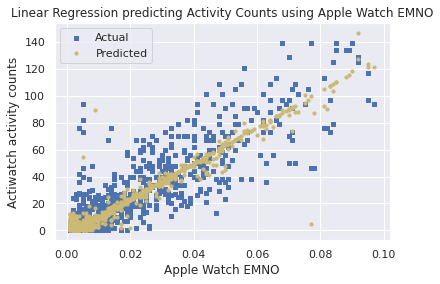

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_test[:, 0], y_test, s=10, c='b', marker="s", label='Actual')
ax1.scatter(X_test[:, 0],abs(model.predict(X_test)), s=10, c='y', marker="o", label='Predicted')
plt.xlabel('Apple Watch EMNO')
plt.ylabel('Actiwatch activity counts')
plt.title('Linear Regression predicting Activity Counts using Apple Watch EMNO')
plt.legend(loc='upper left')
plt.show()

In [26]:
print(check_overall_accuracy(model, 20))

Accuracy: 87.63174173524092
Sensitivity: 86.73254854441389
False Negative Rate: 13.267451455586103
Specificity: 96.66620589785951
False Positive Rate: 3.3337941021404873 
F measure: 92.76234306812185


In [27]:
print(check_overall_accuracy(model, 40))

Accuracy: 96.933819266066
Sensitivity: 97.4711792419664
False Negative Rate: 2.5288207580336146
Specificity: 89.99781201424778
False Positive Rate: 10.002187985752213 
F measure: 98.30062418197006


In [28]:
df_20_tree = get_overall_sleep_metrics(model,20)
df_20_tree['WASO_difference'] = abs(df_20_tree['WASO_predicted'] - df_20_tree['WASO_actual'] )
df_20_tree['TST_difference'] = abs(df_20_tree['TST_predicted'] - df_20_tree['TST_actual'] )
df_20_tree['NWE_difference'] = abs(df_20_tree['nums_wake_events_predicted'] - df_20_tree['nums_wake_events_actual'] )

In [29]:
df_40_tree = get_overall_sleep_metrics(model,40)
df_40_tree['WASO_difference'] = abs(df_40_tree['WASO_predicted'] - df_40_tree['WASO_actual'] )
df_40_tree['TST_difference'] = abs(df_40_tree['TST_predicted'] - df_40_tree['TST_actual'] )
df_40_tree['NWE_difference'] = abs(df_40_tree['nums_wake_events_predicted'] - df_40_tree['nums_wake_events_actual'] )

In [30]:
df_differences = df_20_tree[['Night', 'WASO_difference', 'TST_difference', 'NWE_difference' ]].copy()
df_differences.rename(columns={'WASO_difference': 'WASO_difference_LR_20', 'TST_difference': 'TST_difference_LR_20', 'NWE_difference':'NWE_difference_LR_20'}, inplace=True)

In [31]:
df_differences['WASO_difference_LR_40'] = df_40_tree['WASO_difference']
df_differences['TST_difference_LR_40'] =df_40_tree['TST_difference'] 
df_differences['NWE_difference_LR_40']= df_40_tree['NWE_difference']

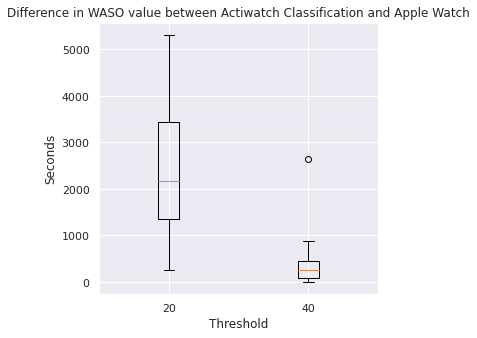

In [32]:
plt.rcParams["figure.figsize"] = (5,5)
plt.boxplot([df_20_tree['WASO_difference'],df_40_tree['WASO_difference']])
plt.xticks([1,2], ['20','40'])
plt.xlabel('Threshold')
plt.ylabel('Seconds')
plt.title('Difference in WASO value between Actiwatch Classification and Apple Watch')
plt.show()

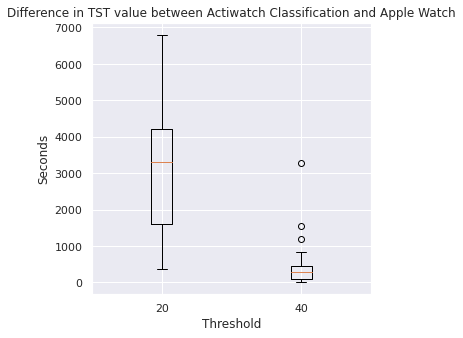

In [33]:
plt.rcParams["figure.figsize"] = (5,5)
plt.boxplot([df_20_tree['TST_difference'],df_40_tree['TST_difference']])
plt.xticks([1,2], ['20','40'])
plt.xlabel('Threshold')
plt.ylabel('Seconds')
plt.title('Difference in TST value between Actiwatch Classification and Apple Watch')
plt.show()

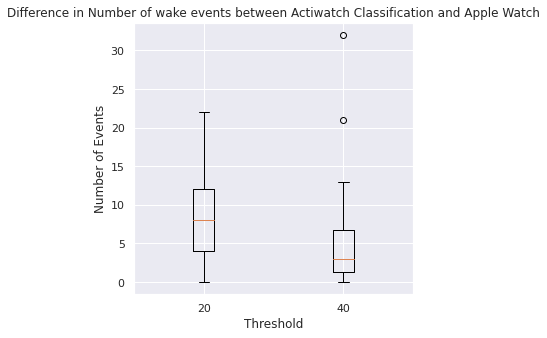

In [34]:
plt.rcParams["figure.figsize"] = (5,5)
plt.boxplot([df_20_tree['NWE_difference'],df_40_tree['NWE_difference']])
plt.xticks([1,2], ['20','40'])
plt.xlabel('Threshold')
plt.ylabel('Number of Events')
plt.title('Difference in Number of wake events between Actiwatch Classification and Apple Watch')
plt.show()

### Test on Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [37]:
regressor.fit(X_train, y_train) 

RandomForestRegressor(random_state=0)

In [38]:
r_sq_2 = regressor.score(X_test, y_test)
print(f"coefficient of determination: {r_sq_2}")

coefficient of determination: 0.8447036919627016


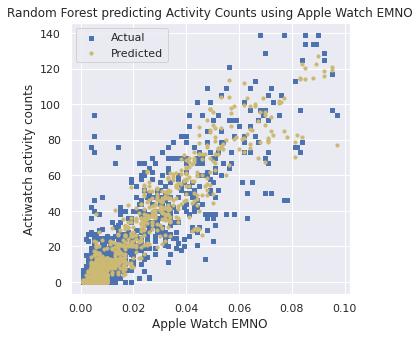

In [39]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_test[:, 0], y_test, s=10, c='b', marker="s", label='Actual')
ax1.scatter(X_test[:, 0],regressor.predict(X_test), s=10, c='y', marker="o", label='Predicted')
plt.xlabel('Apple Watch EMNO')
plt.ylabel('Actiwatch activity counts')
plt.title('Random Forest predicting Activity Counts using Apple Watch EMNO')
plt.legend(loc='upper left')
plt.show()

Test on patient

In [40]:
df_20_tree = get_overall_sleep_metrics(regressor,20)
df_20_tree['WASO_difference'] = abs(df_20_tree['WASO_predicted'] - df_20_tree['WASO_actual'] )
df_20_tree['TST_difference'] = abs(df_20_tree['TST_predicted'] - df_20_tree['TST_actual'] )
df_20_tree['NWE_difference'] = abs(df_20_tree['nums_wake_events_predicted'] - df_20_tree['nums_wake_events_actual'] )
df_20_tree


,Night,WASO_predicted,TST_predicted,nums_wake_events_predicted,WASO_actual,TST_actual,nums_wake_events_actual,WASO_difference,TST_difference,NWE_difference
0,P02_N1,1845,19785,33,1005.0,21360.0,24,840.0,1575.0,9
1,P02_N2,1665,22350,29,1065.0,23400.0,25,600.0,1050.0,4
2,P03_N1,2625,26895,61,2010.0,28905.0,60,615.0,2010.0,1
3,P03_N2,2370,26415,48,1125.0,27705.0,43,1245.0,1290.0,5
4,P04_N1,1665,19215,25,810.0,21165.0,30,855.0,1950.0,5
5,P04_N2,2160,28905,50,1170.0,29895.0,45,990.0,990.0,5
6,P05_N1,405,23490,22,345.0,23970.0,19,60.0,480.0,3
7,P05_N2,630,24495,24,390.0,24780.0,20,240.0,285.0,4
8,P06_N1,630,21270,21,540.0,21420.0,20,90.0,150.0,1
9,P06_N2,2010,33495,64,1335.0,34170.0,56,675.0,675.0,8


In [41]:
thres_20 = [average(df_20_tree['WASO_difference']), average(df_20_tree['TST_difference'])]

In [42]:
df_40_tree = get_overall_sleep_metrics(regressor,40)
df_40_tree['WASO_difference'] = abs(df_40_tree['WASO_predicted'] - df_40_tree['WASO_actual'] )
df_40_tree['TST_difference'] = abs(df_40_tree['TST_predicted'] - df_40_tree['TST_actual'] )
df_40_tree['NWE_difference'] = abs(df_40_tree['nums_wake_events_predicted'] - df_40_tree['nums_wake_events_actual'] )
df_40_tree

,Night,WASO_predicted,TST_predicted,nums_wake_events_predicted,WASO_actual,TST_actual,nums_wake_events_actual,WASO_difference,TST_difference,NWE_difference
0,P02_N1,855,21540,25,1005.0,21360.0,24,150.0,180.0,1
1,P02_N2,660,23835,25,1065.0,23400.0,25,405.0,435.0,0
2,P03_N1,1875,29100,56,2010.0,28905.0,60,135.0,195.0,4
3,P03_N2,960,27840,44,1125.0,27705.0,43,165.0,135.0,1
4,P04_N1,735,21255,29,810.0,21165.0,30,75.0,90.0,1
5,P04_N2,1035,30045,50,1170.0,29895.0,45,135.0,150.0,5
6,P05_N1,375,23940,20,345.0,23970.0,19,30.0,30.0,1
7,P05_N2,450,24720,22,390.0,24780.0,20,60.0,60.0,2
8,P06_N1,450,21510,20,540.0,21420.0,20,90.0,90.0,0
9,P06_N2,1380,34125,56,1335.0,34170.0,56,45.0,45.0,0


In [43]:
thres_40 = [average(df_40_tree['WASO_difference']), average(df_40_tree['TST_difference'])]

In [44]:
df_differences['WASO_difference_RF_20'] = df_20_tree['WASO_difference']
df_differences['TST_difference_RF_20'] =df_20_tree['TST_difference'] 
df_differences['NWE_difference_RF_20']= df_20_tree['NWE_difference']
df_differences['WASO_difference_RF_40'] = df_40_tree['WASO_difference']
df_differences['TST_difference_RF_40'] =df_40_tree['TST_difference'] 
df_differences['NWE_difference_RF_40']= df_40_tree['NWE_difference']

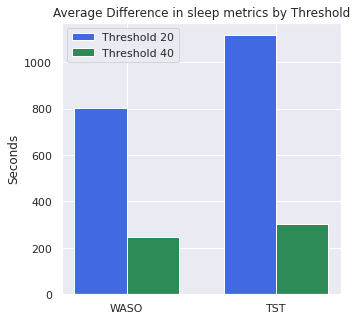

In [45]:
ind = np.arange(2)
width = 0.35 
fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, thres_20, width, color='royalblue')
rects2 = ax.bar(ind+width, thres_40, width, color='seagreen')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( ('WASO', 'TST') )
ax.set_ylabel('Seconds')
ax.legend( (rects1[0], rects2[0]), ('Threshold 20', 'Threshold 40') )
ax.set_title('Average Difference in sleep metrics by Threshold')
plt.show()

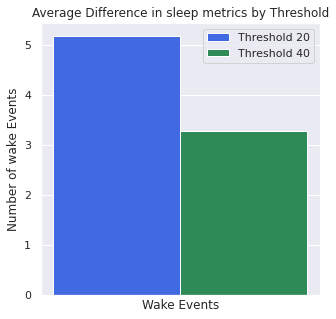

In [46]:
ind = np.arange(1)
width = 0.35 
fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, average(df_20_tree['NWE_difference']), width, color='royalblue')
rects2 = ax.bar(ind+width, average(df_40_tree['NWE_difference']), width, color='seagreen')
ax.set_xticks(ind + width / 2)
ax.set_xlabel( 'Wake Events' )
ax.get_xaxis().set_ticks([])
ax.set_ylabel('Number of wake Events')
ax.legend( (rects1[0], rects2[0]), ('Threshold 20', 'Threshold 40') )
ax.set_title('Average Difference in sleep metrics by Threshold')
plt.show()

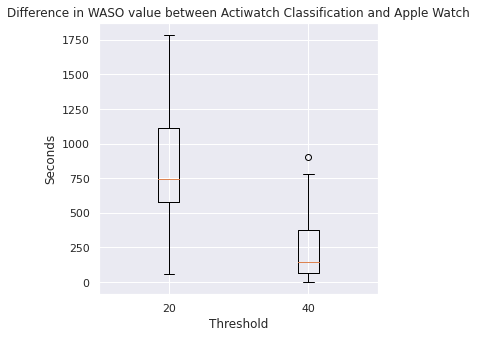

In [47]:
plt.rcParams["figure.figsize"] = (5,5)
plt.boxplot([df_20_tree['WASO_difference'],df_40_tree['WASO_difference']])
plt.xticks([1,2], ['20','40'])
plt.xlabel('Threshold')
plt.ylabel('Seconds')
plt.title('Difference in WASO value between Actiwatch Classification and Apple Watch')
plt.show()

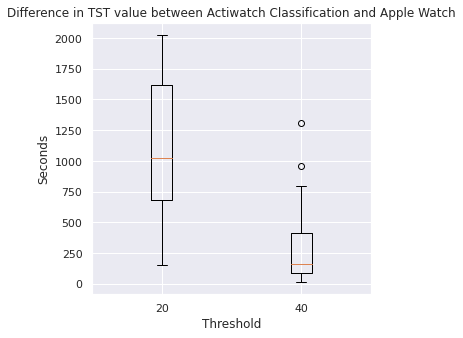

In [48]:
plt.rcParams["figure.figsize"] = (5,5)
plt.boxplot([df_20_tree['TST_difference'],df_40_tree['TST_difference']])
plt.xticks([1,2], ['20','40'])
plt.xlabel('Threshold')
plt.ylabel('Seconds')
plt.title('Difference in TST value between Actiwatch Classification and Apple Watch')
plt.show()

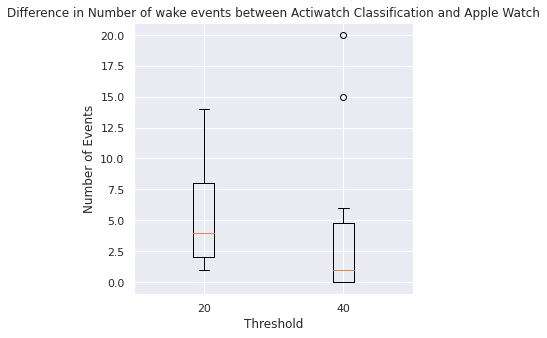

In [49]:
plt.rcParams["figure.figsize"] = (5,5)
plt.boxplot([df_20_tree['NWE_difference'],df_40_tree['NWE_difference']])
plt.xticks([1,2], ['20','40'])
plt.xlabel('Threshold')
plt.ylabel('Number of Events')
plt.title('Difference in Number of wake events between Actiwatch Classification and Apple Watch')
plt.show()

In [50]:
print(check_overall_accuracy(regressor, 20))

Accuracy: 95.7442679872314
Sensitivity: 95.6710273261257
False Negative Rate: 4.3289726738743
Specificity: 96.29022790712578
False Positive Rate: 3.709772092874211 
F measure: 97.6378056892719


In [51]:
print(check_overall_accuracy(regressor, 40))

Accuracy: 98.11904217026935
Sensitivity: 99.52405011145834
False Negative Rate: 0.47594988854166775
Specificity: 82.48831452409561
False Positive Rate: 17.511685475904372 
F measure: 98.97084095022626


Create AUC Curve

for regression look into 
Mean Squared Error (MSE).
Root Mean Squared Error (RMSE).
Mean Absolute Error (MAE)

In [52]:
from sklearn import metrics

In [53]:
y_predicted_test = regressor.predict(X_test)

In [54]:
auc_df_RF= test_df.dropna(subset=['Actiware classification']).copy()
true_result = auc_df_RF['Actiware classification'].to_numpy()
true_result = true_result.astype(int)
predicted_result = auc_df_RF['predicted_sleep'].to_numpy()

In [55]:
fpr, tpr, _ = metrics.roc_curve(true_result,  predicted_result)

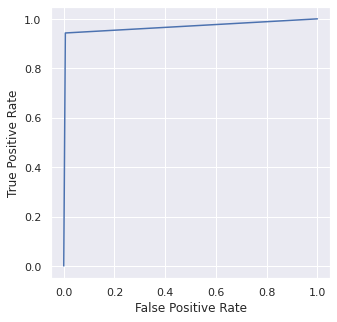

In [56]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Test on Naive Bayes

In [57]:
from sklearn.naive_bayes import GaussianNB

In [58]:
gnb = GaussianNB()

In [59]:
gnb.fit(X_train, y_train)


GaussianNB()

In [60]:
r_sq_3 = gnb.score(X_test, y_test)
print(f"coefficient of determination: {r_sq_3}")

coefficient of determination: 0.9205034002970375


Test on patient

In [61]:
test_df = test_model_on_patient('P03_N1_filtered', gnb,40)
check_accuracy(test_df)

(98.69375907111755,
 99.58484691229891,
 0.4151530877010898,
 86.42857142857143,
 13.57142857142857,
 99.01960784313727)

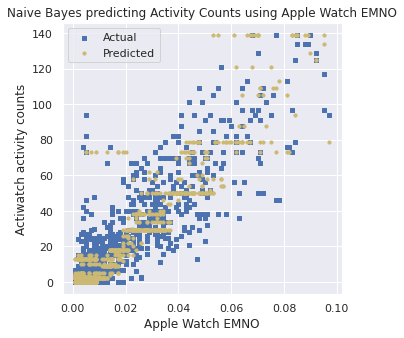

In [62]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_test[:, 0], y_test, s=10, c='b', marker="s", label='Actual')
ax1.scatter(X_test[:, 0],gnb.predict(X_test), s=10, c='y', marker="o", label='Predicted')
plt.xlabel('Apple Watch EMNO')
plt.ylabel('Actiwatch activity counts')
plt.title('Naive Bayes predicting Activity Counts using Apple Watch EMNO')
plt.legend(loc='upper left')
plt.show()

In [63]:
df_20_tree = get_overall_sleep_metrics(gnb,20)
df_20_tree['WASO_difference'] = abs(df_20_tree['WASO_predicted'] - df_20_tree['WASO_actual'] )
df_20_tree['TST_difference'] = abs(df_20_tree['TST_predicted'] - df_20_tree['TST_actual'] )
df_20_tree['NWE_difference'] = abs(df_20_tree['nums_wake_events_predicted'] - df_20_tree['nums_wake_events_actual'] )

In [64]:
df_40_tree = get_overall_sleep_metrics(gnb,40)
df_40_tree['WASO_difference'] = abs(df_40_tree['WASO_predicted'] - df_40_tree['WASO_actual'] )
df_40_tree['TST_difference'] = abs(df_40_tree['TST_predicted'] - df_40_tree['TST_actual'] )
df_40_tree['NWE_difference'] = abs(df_40_tree['nums_wake_events_predicted'] - df_40_tree['nums_wake_events_actual'] )

In [65]:
df_differences['WASO_difference_NB_20'] = df_20_tree['WASO_difference']
df_differences['TST_difference_NB_20'] =df_20_tree['TST_difference'] 
df_differences['NWE_difference_NB_20']= df_20_tree['NWE_difference']
df_differences['WASO_difference_NB_40'] = df_40_tree['WASO_difference']
df_differences['TST_difference_NB_40'] =df_40_tree['TST_difference'] 
df_differences['NWE_difference_NB_40']= df_40_tree['NWE_difference']

In [66]:
print(check_overall_accuracy(gnb, 20))

Accuracy: 95.52163018269634
Sensitivity: 95.85745743793105
False Negative Rate: 4.14254256206895
Specificity: 90.32044771943517
False Positive Rate: 9.67955228056483 
F measure: 97.5211943311877


In [67]:
print(check_overall_accuracy(gnb, 40))

Accuracy: 97.85027662306312
Sensitivity: 99.10285813777855
False Negative Rate: 0.8971418622214486
Specificity: 81.88178089619879
False Positive Rate: 18.11821910380121 
F measure: 98.82575413732947


### Test on SVM

In [68]:
from sklearn import svm

In [69]:
regr = svm.SVR(kernel="linear", C=100, gamma="auto", epsilon = 6)
regr.fit(X_train, y_train)

SVR(C=100, epsilon=6, gamma='auto', kernel='linear')

In [70]:
r_sq_4 = regr.score(X_test, y_test)
print(f"coefficient of determination: {r_sq_4}")

coefficient of determination: 0.7929420328533825


Test on patient

In [71]:
test_df = test_model_on_patient('P03_N1_filtered', regr,40)
check_accuracy(test_df)

(99.17755200774069,
 99.79242345614946,
 0.2075765438505449,
 90.71428571428571,
 9.285714285714292,
 99.32851239669421)

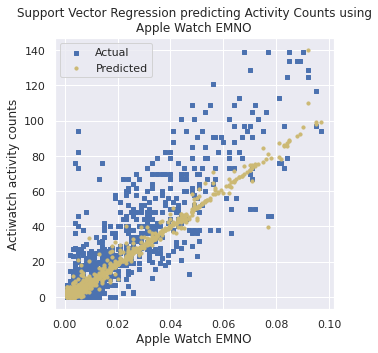

In [72]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_test[:, 0], y_test, s=10, c='b', marker="s", label='Actual')
ax1.scatter(X_test[:, 0],abs(regr.predict(X_test)), s=10, c='y', marker="o", label='Predicted')
plt.xlabel('Apple Watch EMNO')
plt.ylabel('Actiwatch activity counts')
plt.title("\n".join(wrap("Support Vector Regression predicting Activity Counts using Apple Watch EMNO", 60)))
plt.legend(loc='upper left')
plt.show()

In [73]:
df_20_tree = get_overall_sleep_metrics(regr,20)
df_20_tree['WASO_difference'] = abs(df_20_tree['WASO_predicted'] - df_20_tree['WASO_actual'] )
df_20_tree['TST_difference'] = abs(df_20_tree['TST_predicted'] - df_20_tree['TST_actual'] )
df_20_tree['NWE_difference'] = abs(df_20_tree['nums_wake_events_predicted'] - df_20_tree['nums_wake_events_actual'] )

In [74]:
df_40_tree = get_overall_sleep_metrics(regr,40)
df_40_tree['WASO_difference'] = abs(df_40_tree['WASO_predicted'] - df_40_tree['WASO_actual'] )
df_40_tree['TST_difference'] = abs(df_40_tree['TST_predicted'] - df_40_tree['TST_actual'] )
df_40_tree['NWE_difference'] = abs(df_40_tree['nums_wake_events_predicted'] - df_40_tree['nums_wake_events_actual'] )

In [75]:
df_differences['WASO_difference_SVR_20'] = df_20_tree['WASO_difference']
df_differences['TST_difference_SVR_20'] =df_20_tree['TST_difference'] 
df_differences['NWE_difference_SVR_20']= df_20_tree['NWE_difference']
df_differences['WASO_difference_SVR_40'] = df_40_tree['WASO_difference']
df_differences['TST_difference_SVR_40'] =df_40_tree['TST_difference'] 
df_differences['NWE_difference_SVR_40']= df_40_tree['NWE_difference']

In [76]:
print(check_overall_accuracy(regr, 20))

Accuracy: 91.5010888960302
Sensitivity: 90.96740256391023
False Negative Rate: 9.03259743608978
Specificity: 96.10928114884427
False Positive Rate: 3.8907188511557167 
F measure: 95.11330288208933


In [77]:
print(check_overall_accuracy(regr, 40))

Accuracy: 97.31507149468666
Sensitivity: 98.23692381895539
False Negative Rate: 1.7630761810446074
Specificity: 85.85387367240435
False Positive Rate: 14.146126327595654 
F measure: 98.51502401672812


In [78]:
df_differences.columns

Index(['Night', 'WASO_difference_LR_20', 'TST_difference_LR_20',
       'NWE_difference_LR_20', 'WASO_difference_LR_40', 'TST_difference_LR_40',
       'NWE_difference_LR_40', 'WASO_difference_RF_20', 'TST_difference_RF_20',
       'NWE_difference_RF_20', 'WASO_difference_RF_40', 'TST_difference_RF_40',
       'NWE_difference_RF_40', 'WASO_difference_NB_20', 'TST_difference_NB_20',
       'NWE_difference_NB_20', 'WASO_difference_NB_40', 'TST_difference_NB_40',
       'NWE_difference_NB_40', 'WASO_difference_SVR_20',
       'TST_difference_SVR_20', 'NWE_difference_SVR_20',
       'WASO_difference_SVR_40', 'TST_difference_SVR_40',
       'NWE_difference_SVR_40'],
      dtype='object')

In [79]:
WASO_values_20 = [df_differences['WASO_difference_LR_20'], df_differences['WASO_difference_RF_20'],df_differences['WASO_difference_NB_20'],df_differences['WASO_difference_SVR_20']]
WASO_values_40 = [df_differences['WASO_difference_LR_40'], df_differences['WASO_difference_RF_40'],df_differences['WASO_difference_NB_40'],df_differences['WASO_difference_SVR_40']]

TST_values_20 = [df_differences['TST_difference_LR_20'], df_differences['TST_difference_RF_20'],df_differences['TST_difference_NB_20'],df_differences['TST_difference_SVR_20']]
TST_values_40 = [df_differences['TST_difference_LR_40'], df_differences['TST_difference_RF_40'],df_differences['TST_difference_NB_40'],df_differences['TST_difference_SVR_40']]

NWE_values_20 = [df_differences['NWE_difference_LR_20'], df_differences['NWE_difference_RF_20'],df_differences['NWE_difference_NB_20'],df_differences['NWE_difference_SVR_20']]
NWE_values_40 = [df_differences['NWE_difference_LR_40'], df_differences['NWE_difference_RF_40'],df_differences['NWE_difference_NB_40'],df_differences['NWE_difference_SVR_40']]

In [80]:
WAS0_20 = [average(df_differences['WASO_difference_LR_20']),average(df_differences['WASO_difference_RF_20']),
average(df_differences['WASO_difference_NB_20']), average(df_differences['WASO_difference_SVR_20'])]

WAS0_40 = [average(df_differences['WASO_difference_LR_40']),average(df_differences['WASO_difference_RF_40']),
average(df_differences['WASO_difference_NB_40']),average(df_differences['WASO_difference_SVR_40'])]

print('WASO 20: ' + str(average(WAS0_20)))
print('WASO 40: ' + str(average(WAS0_40)))

TST_20 = [average(df_differences['TST_difference_LR_20']),average(df_differences['TST_difference_RF_20']),
average(df_differences['TST_difference_NB_20']), average(df_differences['TST_difference_SVR_20'])]

TST_40 = [average(df_differences['TST_difference_LR_40']),average(df_differences['TST_difference_RF_40']),
average(df_differences['TST_difference_NB_40']),average(df_differences['TST_difference_SVR_40'])]

print('TST 20: ' + str(average(TST_20)))
print('TST 40: ' + str(average(TST_40)))

NWE_20 = [average(df_differences['NWE_difference_LR_20']),average(df_differences['NWE_difference_RF_20']),
average(df_differences['NWE_difference_NB_20']), average(df_differences['NWE_difference_SVR_20'])]

NWE_40 = [average(df_differences['NWE_difference_LR_40']),average(df_differences['NWE_difference_RF_40']),
average(df_differences['NWE_difference_NB_40']),average(df_differences['NWE_difference_SVR_40'])]

print('NWE 20: ' + str(average(NWE_20)))
print('NWE 40: ' + str(average(NWE_40)))

WASO 20: 1424.9999999999998
WASO 40: 281.42045454545456
TST 20: 1766.0795454545455
TST 40: 374.1477272727273
NWE 20: 6.875
NWE 40: 5.454545454545454


In [81]:
average([3,4])

3.5

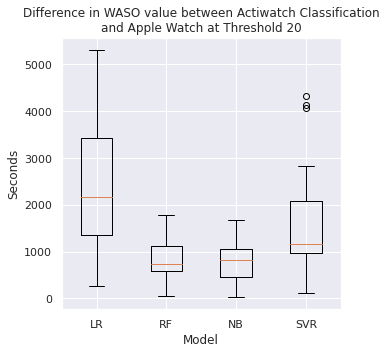

In [82]:
plt.rcParams["figure.figsize"] = (5,5)
plt.boxplot(WASO_values_20)
plt.xticks([1,2,3,4], ['LR','RF','NB','SVR'])
plt.xlabel('Model')
plt.ylabel('Seconds')
plt.title("\n".join(wrap("Difference in WASO value between Actiwatch Classification and Apple Watch at Threshold 20", 60)))
plt.show()

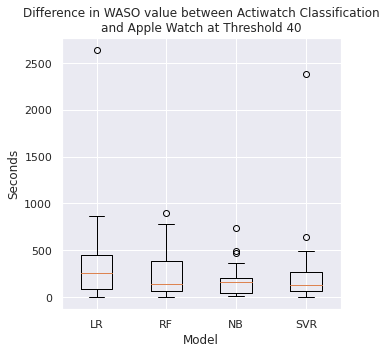

In [83]:
plt.rcParams["figure.figsize"] = (5,5)
plt.boxplot(WASO_values_40)
plt.xticks([1,2,3,4], ['LR','RF','NB','SVR'])
plt.xlabel('Model')
plt.ylabel('Seconds')
plt.title("\n".join(wrap("Difference in WASO value between Actiwatch Classification and Apple Watch at Threshold 40", 60)))
plt.show()

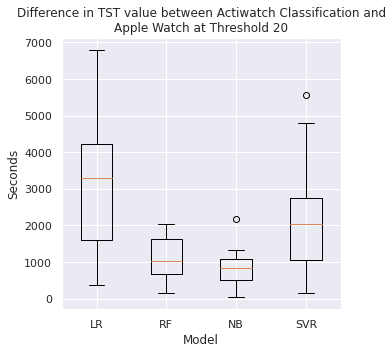

In [84]:
plt.rcParams["figure.figsize"] = (5,5)
plt.boxplot(TST_values_20)
plt.xticks([1,2,3,4], ['LR','RF','NB','SVR'])
plt.xlabel('Model')
plt.ylabel('Seconds')
plt.title("\n".join(wrap("Difference in TST value between Actiwatch Classification and Apple Watch at Threshold 20", 60)))
plt.show()

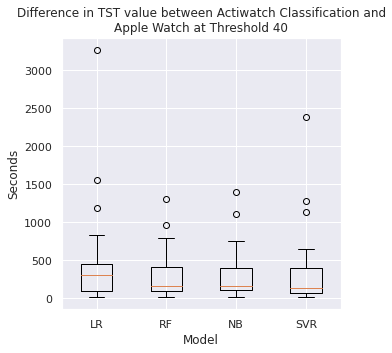

In [85]:
plt.rcParams["figure.figsize"] = (5,5)
plt.boxplot(TST_values_40)
plt.xticks([1,2,3,4], ['LR','RF','NB','SVR'])
plt.xlabel('Model')
plt.ylabel('Seconds')
plt.title("\n".join(wrap("Difference in TST value between Actiwatch Classification and Apple Watch at Threshold 40", 60)))
plt.show()

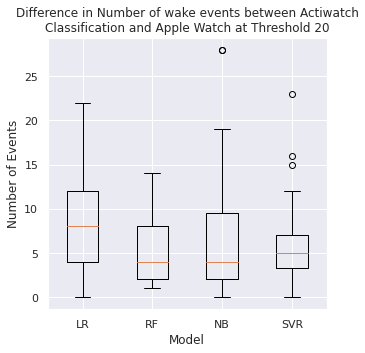

In [86]:
plt.rcParams["figure.figsize"] = (5,5)
plt.boxplot(NWE_values_20)
plt.xticks([1,2,3,4], ['LR','RF','NB','SVR'])
plt.xlabel('Model')
plt.ylabel('Number of Events')
plt.title("\n".join(wrap("Difference in Number of wake events between Actiwatch Classification and Apple Watch at Threshold 20", 60)))
plt.show()

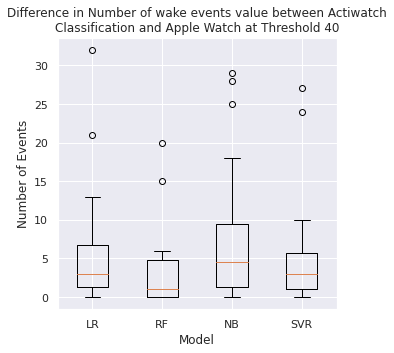

In [87]:

plt.rcParams["figure.figsize"] = (5,5)
plt.boxplot(NWE_values_40)
plt.xticks([1,2,3,4], ['LR','RF','NB','SVR'])
plt.xlabel('Model')
plt.ylabel('Number of Events')
plt.title("\n".join(wrap("Difference in Number of wake events value between Actiwatch Classification and Apple Watch at Threshold 40", 60)))
plt.show()